# Thông tin model:
Mô hình cho bước 2: scibert_based_cased

- Bước 1: phân loại câu dưới dạng phân loại token gán nhãn SOBI:

max_len = 512


- Bước 2: Phân loại token gán nhãn (BILOU, U-PR):

max_len = 64


# Chuẩn bị các thư viện cần thiết

Cài đặt thư viện bioc và transformers

In [ ]:
pip install bioc transformers

     |████████████████████████████████| 4.0 MB 8.3 MB/s 
     |████████████████████████████████| 6.4 MB 51.4 MB/s 
     |████████████████████████████████| 596 kB 87.0 MB/s 
     |████████████████████████████████| 6.6 MB 43.8 MB/s 
     |████████████████████████████████| 895 kB 61.0 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
# import các thư viện
import os
import transformers
import bioc
import math
import torch
import pandas as pd
import numpy as np
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader
from transformers import BertForTokenClassification, AutoModelForTokenClassification
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

In [ ]:
# Kiểm tra colab sử dụng GPU để tăng tốc độ train
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


# Import data

In [ ]:
#@title Thực hiện import data bằng 1 trong 2 cách
#@markdown Cách 1: tải folder BLAR về google drive

#@markdown Cách 2: huấn luyện thử mô hình, tải dữ liệu về ổ cứng tạm thời của colab

method = "download_to_temporary_disk" #@param ["download_to_google_drive", "download_to_temporary_disk"]


if method == 'download_to_google_drive':
  
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/Colab Notebooks/BLAR data') ##Đổi về directory trong drive

else:
  os.chdir('/content')
  directory = './corpus'
  if not os.path.exists(directory):
      os.makedirs(directory)
  os.chdir(directory)
  ## Download data về disk
  !gdown --id 16hOCtaVyuE2LK_n7mHNO_ptm_A-A8kjV
  !gdown --id 1Mj80pavNCcIHB7_e59DVQyv0EoS8bI6a
  os.chdir('/content')

  directory = './model/model_SOBI'
  if not os.path.exists(directory):
      os.makedirs(directory)
  os.chdir(directory)
  ## Download data về disk
  !gdown --id 1Xg7XBdIWs5k76KEB9J1pG8HikPsIdnKM
  !gdown --id 1rjDB8_GmTAvBrzu8qp7TfxORl0zIMm1b
  !gdown --id 1MvJ0Auu0l_XrjcM9prj0xj-E9ckMXO98
  os.chdir('/content')

  directory = './model/2stepFromAllSentenceModel'
  if not os.path.exists(directory):
      os.makedirs(directory)
  os.chdir(directory)
  ## Download data về disk
  !gdown --id 1Lut7rci259_d3waHkdRjS3MGLwBN02Pe
  !gdown --id 1AIBtnfEYgJlmXFBzT0kZrEVnnBfyTjTL
  !gdown --id 10-U7cjGOiZ6Nty7OC3BCtyswP6ilk4VY
  os.chdir('/content')

## Load data từ google drive
### BIOADI corpus
from bioc import biocxml
with open('./corpus/bioadi_bioc_gold.xml', 'r') as fp:
  gold_raw = biocxml.load(fp)

### AB3P corpus
from bioc import biocxml
with open('./corpus/Ab3P_bioc_gold.xml', 'r') as fp:
  ab3p = biocxml.load(fp)


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=16hOCtaVyuE2LK_n7mHNO_ptm_A-A8kjV
To: /content/corpus/bioadi_bioc_gold.xml
100% 2.58M/2.58M [00:00<00:00, 232MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Mj80pavNCcIHB7_e59DVQyv0EoS8bI6a
To: /content/corpus/Ab3P_bioc_gold.xml
100% 2.36M/2.36M [00:00<00:00, 246MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarni

In [ ]:
# Tạo corpus phụ gồm các văn bản không chứa từ viết tắt
n = len(gold_raw.documents)
noAcronym = []
gold_noAcronym = bioc.bioc.BioCCollection()
for i, document in enumerate(gold_raw.documents):
  if len(document.passages[0].annotations) == 0:
    gold_noAcronym.add_document(document)
    noAcronym.append(i)

In [ ]:
# Tạo corpus phụ gồm các văn bản chứa từ viết tắt
n = len(gold_raw.documents)
Acronym = []
gold = bioc.bioc.BioCCollection()
for i, document in enumerate(gold_raw.documents):
  if len(document.passages[0].annotations) != 0:
    gold.add_document(document)
    Acronym.append(i)

# Load SciBERT model

Load pretrained SciBERT Model

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('allenai/scibert_scivocab_cased')
scibert_model = transformers.AutoModel.from_pretrained('allenai/scibert_scivocab_cased')

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# sample tokenization
sample = gold.documents[0].passages[0].text
encoding = tokenizer.encode(sample,
                            return_offsets_mapping=True, 
                            padding='max_length', 
                            truncation=True, 
                            max_length=512)

print(encoding)
print(tokenizer.convert_ids_to_tokens(encoding))

[101, 105, 1174, 1291, 5839, 11986, 8589, 307, 864, 24820, 3254, 16737, 430, 2107, 1422, 136, 9297, 1004, 648, 211, 5839, 11986, 8589, 640, 231, 2771, 5922, 202, 1682, 201, 3683, 6990, 146, 8676, 111, 22330, 6746, 5839, 11986, 26164, 30111, 1820, 1185, 1066, 125, 5839, 11986, 26164, 30111, 231, 1109, 188, 105, 4035, 125, 3918, 211, 18221, 289, 2306, 111, 24820, 3254, 16737, 125, 105, 1291, 2475, 1538, 324, 7900, 5839, 11986, 26164, 578, 1174, 5839, 11986, 8589, 307, 143, 160, 22051, 10936, 30108, 551, 211, 111, 4097, 143, 262, 711, 134, 19304, 30108, 136, 825, 1066, 551, 163, 4434, 3055, 124, 4006, 430, 596, 188, 4712, 659, 21449, 211, 111, 160, 22051, 10936, 30108, 8881, 10369, 5839, 11986, 17511, 16539, 124, 711, 28880, 136, 1755, 23936, 30112, 3581, 430, 136, 9904, 4777, 15344, 10670, 136, 1487, 10409, 9615, 430, 596, 319, 21002, 2337, 211, 4237, 9297, 731, 3407, 202, 111, 160, 22051, 10936, 30108, 11050, 803, 146, 111, 1755, 23936, 30112, 1487, 136, 797, 146, 111, 4284, 1642, 201, 

# Load sentence classification model

### load model

In [ ]:
# Parameter cho SOBI model
MAX_LEN = 512
labels_to_ids_sentence = {'B':0,'I':1,'S':2, 'O':3,'SpecialToken':-100}
ids_to_labels_sentence = {0:'B',1:'I',2:'S', 3: 'O', -100:'SpecialToken'}

In [ ]:
directory = "./model/model_SOBI"
tokenizer = transformers.AutoTokenizer.from_pretrained(directory, local_files_only=True)
model_seq = transformers.AutoModelForTokenClassification.from_pretrained(directory, local_files_only=True)
model_seq.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31116, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
#@title Functions
#@markdown Load các hàm cho mô hình phân loại câu


def ExtractSentenceWithAcronym(original_passage):
  # this function will return new passage with annotated sentences


  passage = deepcopy(original_passage)
  text = passage.text
  # extract annotation
  sf_offset_stack_unsort = dict()
  for i, annotation in enumerate(passage.annotations):
    if i%2 == 0:
      sf_offset_stack_unsort[passage.annotations[i].total_span.offset] = i #extract the SF offset only
  offsetList = [offset for offset,i in sf_offset_stack_unsort.items()]
  
  sf_offset_stack = []
  while offsetList:
    minoffset = min(offsetList)
    idx = sf_offset_stack_unsort[minoffset]
    sf_offset_stack.append([idx, passage.annotations[idx].total_span.offset])
    offsetList.remove(minoffset)

  
  # Sentence extraction
  ## Presumption: 
  ### SF always stands before LF in corpus annotation list
  ### Sentence extraction by: '. '
  ### Sentence starts with CASED character
  ### Sentence length > 20 characters

  rawSentenceList = text.split('. ') #split passage to list of sentence
  cased_alphabet = 'ABCEDEFGHIJKLMNOPQRSTUVWXYZ'
  sentenceList = []
  for i, raw_sentence in enumerate(rawSentenceList):
    if raw_sentence[-1] != '.':
      raw_sentence += '.' # add . if sentence doesn't have
    if raw_sentence[0] in cased_alphabet and len(raw_sentence) >10:
      sentenceList.append(raw_sentence)
    else:
      if sentenceList:
        sentenceList[-1] += ' ' + raw_sentence
      else:
        sentenceList.append(raw_sentence)


  # Add annotation for sentence
  pointer = 0
  for sentence in sentenceList:
    bioc_sentence = bioc.bioc.BioCSentence()
    bioc_sentence.text = sentence
    while len(sf_offset_stack):
      if sf_offset_stack[0][1] < pointer + len(sentence):
        sf = sf_offset_stack.pop(0)
        bioc_sentence.annotations.append(passage.annotations[sf[0]]) # get SF annotation
        bioc_sentence.annotations.append(passage.annotations[sf[0]+1]) # get LF annotation
        bioc_sentence.annotations[-2].locations[0].offset -= pointer # change SF offset to sentence (originally was offset passage)
        bioc_sentence.annotations[-1].locations[0].offset -= pointer # change LF offset to sentence (originally was offset passage)  
      else:
        break
    bioc_sentence.offset = pointer
    pointer += len(sentence) + 1 # move pointer to next sentence, 1 for .
    passage.add_sentence(bioc_sentence) # add sentence to passage
      
  return passage
        

def PredictTokenSentence(text):
  # This function returns predictions of token in Sentence Classification task
  text = text.split(' ')
  inputs = tokenizer(text,
                    is_split_into_words=True,
                    return_offsets_mapping=True, 
                    padding='max_length', 
                    truncation=True, 
                    max_length=512,
                    return_tensors="pt")
  # move to gpu
  ids = inputs["input_ids"].to(device)
  mask = inputs["attention_mask"].to(device)
  # forward pass
  outputs = model_seq(ids, attention_mask=mask)
  logits = outputs[0]

  active_logits = logits.view(-1, model_seq.num_labels) # shape (batch_size * seq_len, num_labels)
  flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

  tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
  token_predictions = [ids_to_labels_sentence[i] for i in flattened_predictions.cpu().numpy()]
  wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

  prediction = []
  for token_pred, mapping in zip(wp_preds, inputs["offset_mapping"].squeeze().tolist()):
    #only predictions on first word pieces are important
    if mapping[0] == 0 and mapping[1] != 0:
      prediction.append(token_pred[1])
    else:
      continue
  return prediction

def PredictSentenceWithABBR(text):
  # This function returns list of predicted correct sentence with LF/SF pairs
  text_split = text.split(' ')
  prediction = PredictTokenSentence(text)
  sentenceList = []
  for i in range(len(prediction)-1):
    if prediction[i] == 'B':
      for j in range(i+1, len(prediction)):
        if prediction[j] in 'BS':
          sentence = ' '.join(text_split[i:j])
          if j-i>4: # at least 5 words per sentence
            sentenceList.append(sentence)
          break
        elif j == len(prediction)-1:
          sentence = ' '.join(text_split[i:])
          sentenceList.append(sentence)
          break               
  return sentenceList
  
def PredictBiocSentenceWithABBR(passage):
  # This function return predicted BioC formated sentences form Gold corpus
  sentences_from_passage = ExtractSentenceWithAcronym(passage).sentences
  sentenceList = PredictSentenceWithABBR(passage.text)
  biocSentenceList = []
  for sentence in sentences_from_passage:
    for i, annotation in enumerate(sentence.annotations):
      if i%2 == 0 :
        haveSF = sentence.annotations[0].text in ' '.join(PredictSentenceWithABBR(passage.text))
        haveLF = []
        for word in sentence.annotations[1].text.split(' '):
          if word in ' '.join(PredictSentenceWithABBR(passage.text)):
            haveLF.append(1)
          else:
            haveLF.append(0)
        haveLF = bool(np.prod(haveLF))
        if haveSF and haveLF:
          if sentence not in biocSentenceList:
            biocSentenceList.append(sentence)

    if not sentence.annotations:
      if sentence.text in sentenceList:
        biocSentenceList.append(sentence)
      else:
        for predicted_sentence in sentenceList:
          if predicted_sentence in sentence.text:
            biocSentenceList.append(sentence)

  return biocSentenceList

### Create corpus for step 2 token classification model with tagged token 

In [ ]:
#@title Functions
def BIOTagSequenceWithAcronym(original_passage):
  # this function will return list of token's labels
  passage = deepcopy(original_passage)
  text = passage.text
  # extract annotation
  sf_offset_stack = []
  for i, annotation in enumerate(passage.annotations):
    if i%2 == 0:
      sf_offset_stack.append([i,passage.annotations[i].total_span.offset]) #extract the SF offset only

  # Sentence extraction
  ## Presumption: 
  ### SF always stands before LF in corpus annotation list
  ### Sentence extraction by: '. '
  ### Sentence starts with CASED character
  ### Sentence length > 20 characters

  rawSentenceList = text.split('. ') #split passage to list of sentence
  
  cased_alphabet = 'ABCEDEFGHIJKLMNOPQRSTUVWXYZ'
  sentenceList = []
  for i, raw_sentence in enumerate(rawSentenceList):
    if raw_sentence[-1] != '.':
      raw_sentence += '.' # add . if sentence doesn't have
    if raw_sentence[0] in cased_alphabet and len(raw_sentence) >20:
      sentenceList.append(raw_sentence)
    else:
      if sentenceList:
        sentenceList[-1] += ' ' + raw_sentence
      else:
        sentenceList.append(raw_sentence)
  
  # add annotation for sentence
  pointer = 0
  sentenceTag = ['NOTcontainSFLF']*len(sentenceList)
  for i,sentence in enumerate(sentenceList):
    while len(sf_offset_stack):
      if sf_offset_stack[0][1] < pointer + len(sentence):
        sf = sf_offset_stack.pop(0)
        sentenceTag[i]= 'containSFLF'  
      else:    
        break
    
    pointer += len(sentence) + 1 # move pointer to next sentence, 1 for .



  wordTag = []
  for i,sentence in enumerate(sentenceList):
    sentence_wordlength = len(sentence.split(' '))
    if sentenceTag[i] == 'containSFLF':
      wordTag += 'B'
      wordTag += ['I']*(sentence_wordlength-1)
    elif sentenceTag[i] == 'NOTcontainSFLF':
      wordTag += 'S'
      wordTag += ['O']*(sentence_wordlength-1)
  return wordTag
        

In [ ]:
#@title create all sentence corpus
#@markdown Tạo training corpus dưới dạng tất cả các câu chứa từ viết tắt/định nghĩa hoặc không
sentence_corpus = []
tag_corpus = []

for i,document in enumerate(gold_raw.documents):
  sentence_corpus.append(document.passages[0].text)
  tag_corpus.append(BIOTagSequenceWithAcronym(document.passages[0]))
sentence_df = pd.DataFrame({'sentence':sentence_corpus,'labels':tag_corpus})


Token_datalist = [] 
for i in range(sentence_df.shape[0]):
  Token_datalist += ExtractSentenceWithAcronym(gold_raw.documents[i].passages[0]).sentences

In [ ]:
#@title Functions for BILOU tag
def BILOUTagForCharacter(passage):
  text = passage.text
  biloutag = ['O']*len(text)
  annotations = passage.annotations

  for i, annotation in enumerate(annotations):
    if i % 2 == 0:

      biloutag[annotation.total_span.offset : annotation.total_span.offset + annotation.total_span.length] = ['U-SF']*annotation.total_span.length
      if text[annotation.total_span.offset-1] == '(':
        biloutag[annotation.total_span.offset-1] = 'U-PR'
        biloutag[annotation.total_span.offset + annotation.total_span.length] = 'U-PR'
    else:
      biloutag[annotation.locations[0].offset] = 'B'
      biloutag[annotation.locations[0].offset + annotation.locations[0].length-1] = 'L'
      biloutag[annotation.locations[0].offset + 1 : annotation.locations[0].offset + annotation.total_span.length-1] = ['I']*(annotation.total_span.length-2)
  for i,c in enumerate(text):
    if c == ' ':
      biloutag[i] = 'SPACE'
  return biloutag

def TokenBILOU(token_ids, characterBILOU,tokenizer= tokenizer):

  noSpaceCharacterBILOU = [character for character in characterBILOU if character != 'SPACE']
  
  tokenList = tokenizer.convert_ids_to_tokens(token_ids['input_ids'])
  character_count = 0
  tokenTag = []

  for token in tokenList:
    if token[0:2] == '##':
      token = token[2:]
    elif token[0] == '[':
      token = ''
      tokenTag.append('TAG')
      continue
    n = len(token)
    extractTag = noSpaceCharacterBILOU[character_count:character_count+n]
    if extractTag[0] == 'B':
      tokenTag.append('B-LF')
    elif extractTag[0] == 'U-PR':
      tokenTag.append('U-PR')
    elif extractTag[0] == 'U-SF':
      tokenTag.append('U-SF')
    elif extractTag[0] == 'L':
      tokenTag.append('L-LF')
    elif extractTag[0] == 'O':
      tokenTag.append('O')
    elif extractTag[0] == 'I':
      if extractTag[-1] == 'L':
        tokenTag.append('L-LF')
      else:
        tokenTag.append('I-LF')

    character_count += n

  return tokenTag


# Tagging scheme
labels_to_ids = {'B-LF':0,
                 'I-LF':1,
                 'L-LF':2,
                 'O':3,
                 'U-SF':4,
                 'U-PR':5,
                 'TAG':6}
ids_to_labels = {v:k for k,v in labels_to_ids.items()}

(array([2.741e+03, 6.438e+03, 1.483e+03, 2.120e+02, 2.900e+01, 1.100e+01,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  15.6,  30.2,  44.8,  59.4,  74. ,  88.6, 103.2, 117.8,
        132.4, 147. ]),
 <a list of 10 Patch objects>)

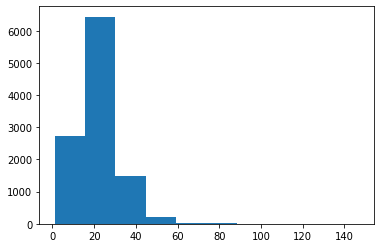

In [ ]:
# plot histogram of sentence length
plt.hist([len(sentence.text.split(' ')) for sentence in Token_datalist])

In [ ]:
MAX_LEN = 64
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 3e-06
MAX_GRAD_NORM = 10

# TokenClassification model

## Preprocess data

In [ ]:
# create dataframe
datalist = []
for i, sentence in enumerate(Token_datalist):
  datalist.append([sentence.text, BILOUTagForCharacter(sentence)])
dataframe = pd.DataFrame(datalist, columns = ['text','character_bilou'])

In [ ]:
# Create dataset class for input to model
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
  def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        text = self.data.text[index] 
        character_labels = self.data.character_bilou[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(text, 
                                  return_offsets_mapping=True, 
                                  padding='max_length', 
                                  truncation=True, 
                                  max_length=self.max_len)
        
        labels = TokenBILOU(encoding, character_labels)
        encoded_labels = [labels_to_ids[label] for label in labels]

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
       
        return item

  def __len__(self):
        return self.len

In [ ]:
# train test split
train_size = 0.8
train_dataset = dataframe.sample(frac=train_size,random_state=200)
test_dataset = dataframe.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(dataframe.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (10916, 2)
TRAIN Dataset: (8733, 2)
TEST Dataset: (2183, 2)


In [ ]:
# Check if dataset is correctly labeled
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[2]["input_ids"]), training_set[2]["labels"]):
  print('{0:10}  {1}'.format(token, label))

[CLS]       6
we          3
also        3
found       3
more        3
alternatively  3
splice      3
##d         3
exons       3
that        3
can         3
give        3
rise        3
to          3
heterogeneous  3
transcripts  3
.           3
[SEP]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6
[PAD]       6


## Model 
Thực hiện cell này để train lại model

####Preparation

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
# load pretrained model with new output_length
model = AutoModelForTokenClassification.from_pretrained('allenai/scibert_scivocab_cased', num_labels=len(labels_to_ids))

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initial

In [ ]:
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31116, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
# sample input before training
inputs = training_set[16]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
initial_loss = outputs[0]
initial_loss

tensor(1.8617, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
# check logits if model has random prediction
-math.log(1/8)

2.0794415416798357

####Training

In [ ]:
#@title Optimizer
LEARNING_RATE = 3e-5 #@param {type:"number"}
optimizer = 'Adam' #@param {type:'string'}
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
#@title Define traning function
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
  
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
        
        tr_logits = outputs[1]
        loss = outputs[0]

        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 2==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss at training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != 6 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
#@title Train
EPOCHS = 5 #@param {type:"integer"}
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss at training steps: 1.9936645030975342
Training loss at training steps: 1.4928655624389648
Training loss at training steps: 1.1530862689018249
Training loss at training steps: 0.9121106692722866
Training loss at training steps: 0.7548153383864297
Training loss at training steps: 0.6472382355820049
Training loss at training steps: 0.5670839015107888
Training loss at training steps: 0.5149315024415652
Training loss at training steps: 0.46639549030977134
Training loss at training steps: 0.43386123917604746
Training loss at training steps: 0.4036850201941672
Training loss at training steps: 0.37904789460741956
Training loss at training steps: 0.358120718896389
Training loss at training steps: 0.34042291977891215
Training loss at training steps: 0.32173575024152623
Training loss at training steps: 0.3061665979123885
Training loss at training steps: 0.29180707884105767
Training loss at training steps: 0.2797163802598204
Training loss at training steps: 0.268519

KeyboardInterrupt: ignored

In [ ]:
#@title Evaluation
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            
            loss = outputs[0]
            eval_logits = outputs[1]
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 20==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 20 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions
labels, predictions = valid(model, testing_loader)

Validation loss per 20 evaluation steps: 0.023345759138464928
Validation loss per 20 evaluation steps: 0.07870708657927546
Validation loss per 20 evaluation steps: 0.04985581991822095
Validation loss per 20 evaluation steps: 0.03514025227136177
Validation loss per 20 evaluation steps: 0.027975429951272227
Validation loss per 20 evaluation steps: 0.026407252391022262
Validation loss per 20 evaluation steps: 0.02531862613232229
Validation loss per 20 evaluation steps: 0.023142984185135818
Validation loss per 20 evaluation steps: 0.021366173195850064
Validation loss per 20 evaluation steps: 0.024248603719977394
Validation loss per 20 evaluation steps: 0.02374020032056165
Validation loss per 20 evaluation steps: 0.024448584549287566
Validation loss per 20 evaluation steps: 0.023858698390902957
Validation loss per 20 evaluation steps: 0.02303181583843715
Validation loss per 20 evaluation steps: 0.022011451206080536
Validation loss per 20 evaluation steps: 0.02134579332488159
Validation loss

#### Save model

In [ ]:
directory = "./model/newstep2model" # Đặt tên cho model


if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(directory)
# save the model weights and its configuration file
model.save_pretrained(directory)
print('All files saved')

All files saved


Load model

In [ ]:
directory = "./model/newstep2model"
tokenizer = transformers.AutoTokenizer.from_pretrained(directory, local_files_only=True)
model = transformers.AutoModelForTokenClassification.from_pretrained(directory, local_files_only=True)
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31116, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

#### Inference
Xem notebook "BLARimplement - SOBI-FromAll"